# Population genetics

We have already looked into the number of heterozygous sites per individual. This is a proxy for diversity, and you can see the effect of the out-of-Africa bottleneck from relatively raw data.

To conclude this course, I cannot give a comprehensive insight into PopGen, but I will show how you can make a PCA from the 1000 Genomes data!

## Principle Component Analysis

### [What is a PCA?](https://en.wikipedia.org/wiki/Principal_component_analysis)

* A statistical method to reduce dimensionality of the data.
* *E.g.* 2504 individuals X 2000000 SNPs
* Many SNPs are observed across multiple individuals: co-variance
* Co-variance shows how similar individuals are - populations cluster with each other
* (unsupervised = the method does not know the labels)

### PCA in population genetics

It is a widely used summary statistic for genotype data. In many papers, it is shown as an exploratory step - we have sequenced new individuals, where do they fall in worldwide or large-scale diversity? This works for humans and many other species with sufficient amounts of data.

Here an example from [humans](https://doi.org/10.1038%2Fnature07331): 

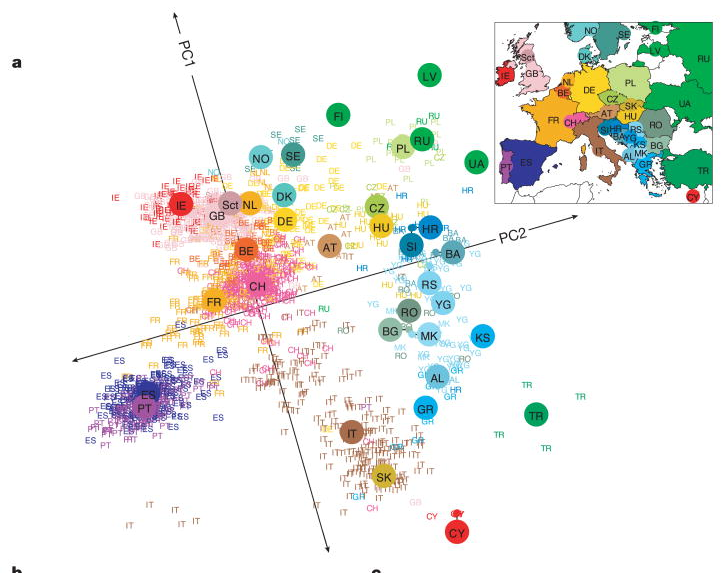

Here one from [Gorillas](https://doi.org/10.1038%2Fs41559-023-02145-2): 

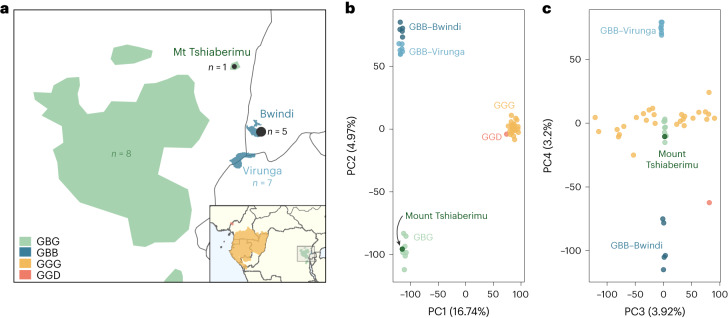


## A simple PCA in R

### Data preparation

Now, we have the data on chr18 from the 1000 Genomes data, and we have done quite some things with them. What we need now is a genotype matrix, or a table of 0s and 1s which can be used by a statistical method. This table should also not have missing data, or other states than 0 and 1.

Another neat feature of `bcftools` is that it actually can also transform `vcf` formatted files into anything you need. In this case, we really just want to have these numbers without anything else. `bcftools query` is good for that, since you can define which fields to extract, and how to separate them.

* Let's do it in one go!

```
bcftools view -m 2 -M 2 -v snps chr18.vcf.gz | bcftools query -f '[%GT ]\n' > allgts.txt
```

* This is still a very big file! Let's "thin" it a bit by randomly taking 100000 SNPs:

```
shuf -n 100000 allgts.txt > somegts.txt
```

There could be different ways of doing this, but here this way is convenient to keep it simple.

* Then we can switch into `R`.


### Data preparation in R

```
R --vanilla

snps<-read.table("somegts.txt", sep=" ",header=F,comment.char="")
head(snps)
```

* Note that the separator is now a space, because that is how we defined it in the previous step. However, this was adding a last space to the end of the file, and R believes there is a (empty) column.

```
snps<-snps[,-2505]

table(snps[,1])
```

Now, these are not really numbers, but genotypes...

* A very easy way to turn them into single numbers would be using the `ifelse` statement like this:

```
snps[,1]<-ifelse(snps[,1]=="0|0",0,snps[,1])
snps[,1]<-ifelse(snps[,1]=="1|1",2,snps[,1])
snps[,1]<-ifelse(snps[,1]%in%c("0|1","1|0"),1,snps[,1])
table(snps[,1])
```

* However:

```
is.numeric(snps[,1])
snps[,1]<-as.numeric(snps[,1])
is.numeric(snps[,1])
```

This looks better, but you certainly don't want to type in 2503 more times the same things, and you would very likely make mistakes on the way.

* Let's use a `for` loop and nested `ifelse` statements to make it easier! As a side-effect, the whole column will be numeric as well!

```
for (j in (2:2504)) { snps[,j]<-ifelse(snps[,j]=="0|0",0,ifelse(snps[,j]=="1|1",2,ifelse(snps[,j]%in%c("0|1","1|0"),1,NA))) }


table(snps[,3])
table(snps[,666])
is.numeric(snps[,2024])
```

I would note that at this stage it is ok to do things that way. But next level would be to write a `function` to make it more efficient... If you feel that coming up with efficient solutions is complicated, that is fine - it is a matter of practice and experience. We need to learn things in order to do them.


### Calculating the PCA

* Did we forget anything? Ah, yes, we may need the proper library to calculate this! A possible (and very nice) one is [adegenet](https://adegenet.r-forge.r-project.org/).

FYI: R has many packages, and often they are not pre-installed on a computer/structure. If that is the case, you may succeed with `install.packages("adegenet")`. Fortunately, we have it available here!

The method we want to use is called `dudi.pca`. It needs the individuals in the rows, and the positions in the columns, that is, a transposed table to be done with `t()`. As you see, nested functions are very common in `R`, do combine things on the fly without intermediate objects. 

* Let's to this:

```
library("adegenet")

pca_object <- dudi.pca(t(snps),nf=20,scannf=F)

tb<-list()
for (j in (1:ncol(snps)))  { tb[[j]]<-table(snps[,j]) }

pca_object
summary(pca_object)
```

This works so far! We have created a higher-level `R` object with lots of information. Important are the coordinates for each individual, which are in the sub-object called `li`, which we can access with the `$` sign.

### Plotting the PCA

* Let's plot this!

```
pdf("PCA_1000g.pdf",12,12)
plot(pca_object$li[,1],pca_object$li[,2])
dev.off()
```

Ok, this is just some distribution... It is nicer to color it. For this, we need the metadata again. In `R`, we can then create a matching colour vector:

```
meta<-read.table("~/test/integrated_call_samples_v3.20130502.ALL.panel", sep="\t",header=T,fill=T)
mypops<-c("AFR","SAS","EUR","EAS","AMR")
cols=c("blue","green","orange","yellow","red")

colvector<-meta$super_pop
for (pop in (1:length(mypops))) { colvector<-gsub(mypops[pop],cols[pop],colvector) }
```
* Let's plot it!

```
pdf("PCA_1000g_col.pdf",12,12)
plot(pca_object$li[,1],pca_object$li[,2],col=colvector)
legend("topright",legend=mypops, fill=cols,bty="n" )
dev.off()
```

This is actually already quite good - considering that it is just a part of chromosome 18! We can do some more polishing to make it look nicer, and add the information how much of the variation is explained by these first two PCs.

* Let's add nice axis labels (`xlab` and `ylab`), and points instead of empty circles (with `pch`):


```
percent_variation=round(pca_object$eig/sum(pca_object$eig)*100,2)
pdf("PCA_1000g_nice.pdf",12,12)
plot(pca_object$li[,1],pca_object$li[,2],col=colvector,pch=16,
    xlab=paste("PC1"," (",percent_variation[1],"%)",sep=""),
    ylab=paste("PC",2," (",percent_variation[2],"%)",sep=""),
    main=paste("PCA of 1000G, chr18"))
legend("topright",legend=mypops, fill=cols,bty="n" )
dev.off()
```

Now, this looks good, and you can gain some insight into the relationships of these populations!

Since the 1000G data is widely used, we can compare to one previously published plot.

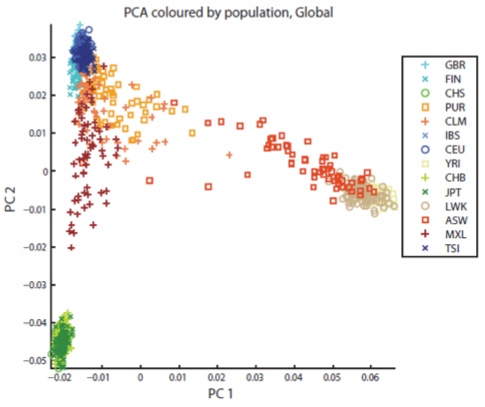


# So, we reached the end of the course!
